# Sparkify notebook "Data Exploration" on AWS

This notebook connects to the full "Sparkify" dataset on an S3 storage at AWS. It bases on the local evaluation of the small dataset provided by udacity. The PySpark Kernel available on the EMR-Notebook at AWS misses some of the python libraries I needed to process my data and the code for plotting the data differs from my local notebook. A very good introduction on how to adjust the code is provided by Amazon: https://aws.amazon.com/de/blogs/big-data/install-python-libraries-on-a-running-cluster-with-emr-notebooks/

## install missing libraries

In [1]:
sc.install_pypi_package("pandas==0.25.1") #Install pandas version 0.25.1 
sc.install_pypi_package("matplotlib==3.1.1", "https://pypi.org/simple") #Install matplotlib from given PyPI repository
sc.install_pypi_package("openpyxl") #Install openpyxl
sc.install_pypi_package("seaborn") #Install seaborn

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1620324993655_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…



  Running setup.py bdist_wheel for retrying: started
  Running setup.py bdist_wheel for retrying: finished with status 'done'
  Stored in directory: /var/lib/livy/.cache/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying



## import all libraries needed

In [2]:
# Starter code
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import round as Fround
from pyspark.sql.functions import isnan, when, count, col

import datetime

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## setup spark session

In [3]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## import data from S3-repository

In [4]:
# Read in full sparkify dataset
event_data = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
user_log = spark.read.json(event_data)
user_log.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

## define function for aggregation by week

In [5]:
#function to extract calendar week from ts
spark.udf.register("get_week", lambda x: str(datetime.datetime.fromtimestamp(x / 1000.0).isocalendar()[1])+"/"+str(datetime.datetime.fromtimestamp(x / 1000.0).isocalendar()[0]))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<function <lambda> at 0x7f2b3aa899e0>

## clean dataset

In [6]:
#count all nan, Null or empty values for each row
user_log.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in user_log.columns]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+
| artist|auth|firstName|gender|itemInSession|lastName| length|level|location|method|page|registration|sessionId|   song|status| ts|userAgent|userId|
+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+
|5410228|   0|   778479|778479|            0|  778479|5408927|    0|  778479|     0|   0|      778479|        0|5412947|     0|  0|   778479|     0|
+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+

In [7]:
#drop invalid (guest) userId's
user_log_valid = user_log.where(user_log.userId != "")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
#check if any of the played songs have true Null values
user_log.where((user_log.artist.isNull()) & (user_log.page == 'Next Song')).count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0

## create new feature "membership_days" as mutual time reference for all users

In [9]:
user_log=user_log.withColumn("membership_days", Fround((col('ts')/1000-col('registration')/1000)/86400).cast(IntegerType()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## create view for SQL queries

In [10]:
user_log.createOrReplaceTempView("user_log_table")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## explore column "page" statistic and visualize results

In [11]:
cols=user_log.columns
temp=pd.DataFrame()
for col in cols:
    temp[col]=spark.sql('''
              SELECT count(DISTINCT {0}) as {1}
              FROM user_log_table 
              '''.format(col, col)
              ).toPandas()[col]
unique_values=np.transpose(temp).rename(columns={0:'unique_values'})

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
unique_values

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                 unique_values
artist                   38337
auth                         4
firstName                 5467
gender                       2
itemInSession             1429
lastName                  1000
length                   23748
level                        2
location                   886
method                       2
page                        22
registration             22247
sessionId               228713
song                    253564
status                       3
ts                     5191762
userAgent                   85
userId                   22278
membership_days            415

In [13]:
page_statistics=user_log.groupBy('page').count().sort(desc("count")).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

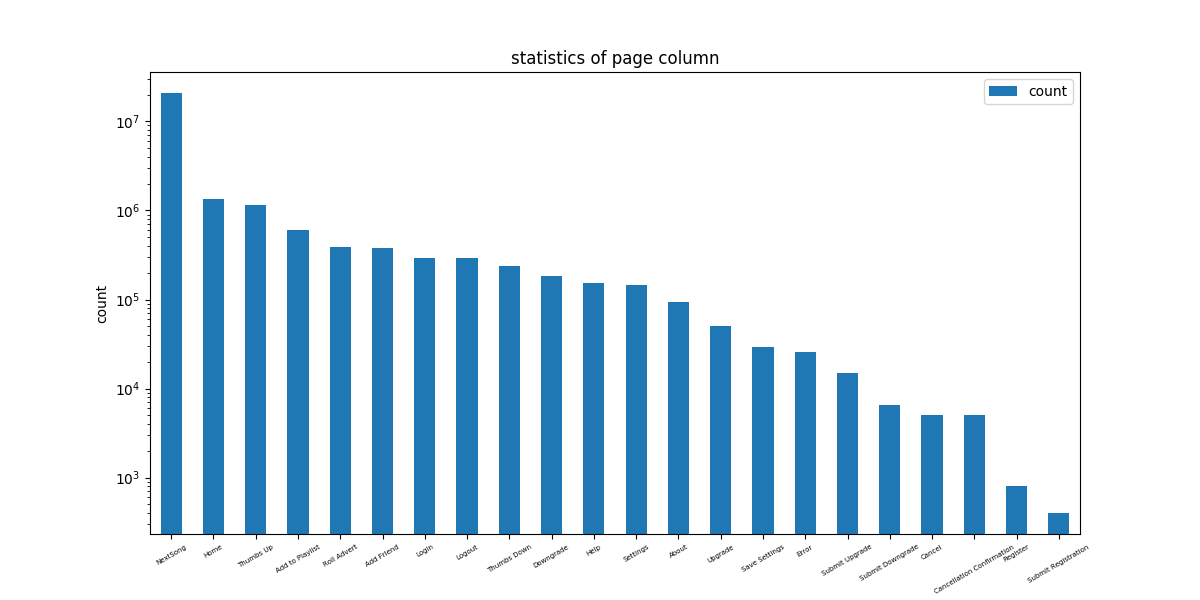

In [14]:
plt.clf()
plt.figure(figsize=(12,9))
page_statistics.plot(kind='bar', x='page',y='count', rot=30, figsize=(12,6), logy=True)
plt.xticks(fontsize=5)
plt.title('statistics of page column')
plt.xlabel('page')
plt.ylabel('count')
%matplot plt

## explore statistic for "churn" users
### gender dependency

In [15]:
users_churned=spark.sql('''
          SELECT *, ts/1000 timestamp, get_week(ts) as week
          FROM user_log_table 
          WHERE page == "Cancellation Confirmation"
          SORT BY userId ASC
          '''
          )
df_all=users_churned.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

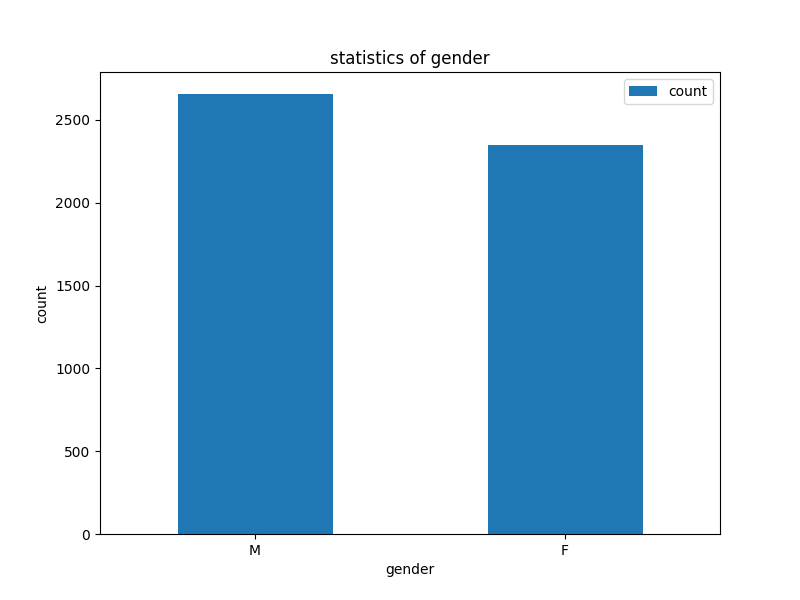

In [16]:
df=users_churned.groupBy("gender").count().toPandas()
plt.clf()
df.plot(kind='bar', x='gender',y='count', rot=0, legend=True, figsize=(8,6))
plt.title('statistics of gender')
plt.xlabel('gender')
plt.ylabel('count')
%matplot plt

### level dependency

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

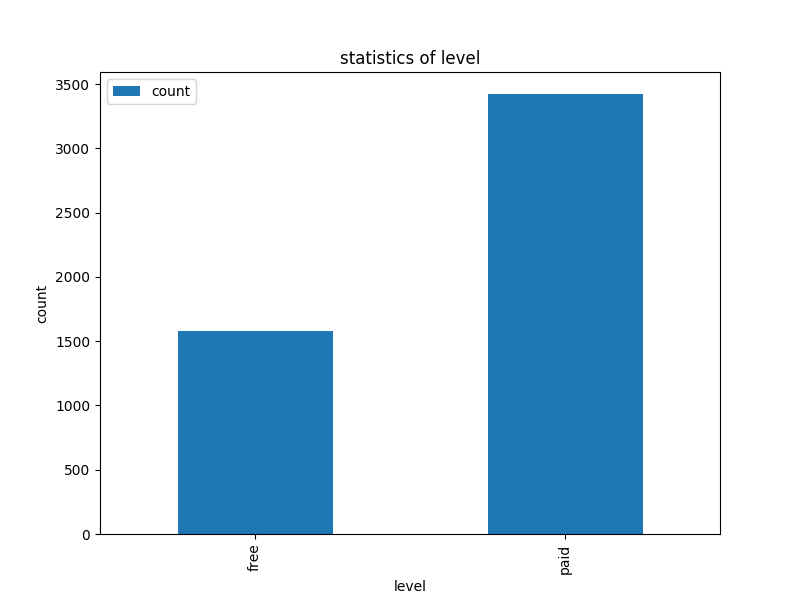

In [17]:
#subscription dependency
df2=users_churned.groupBy("level").count().toPandas()
plt.clf()
df2.plot(kind='bar', x='level',y='count', legend=True, figsize=(8,6))
plt.title('statistics of level')
plt.xlabel('level')
plt.ylabel('count')
%matplot plt

### distribution of membership day on which service was cancelled

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

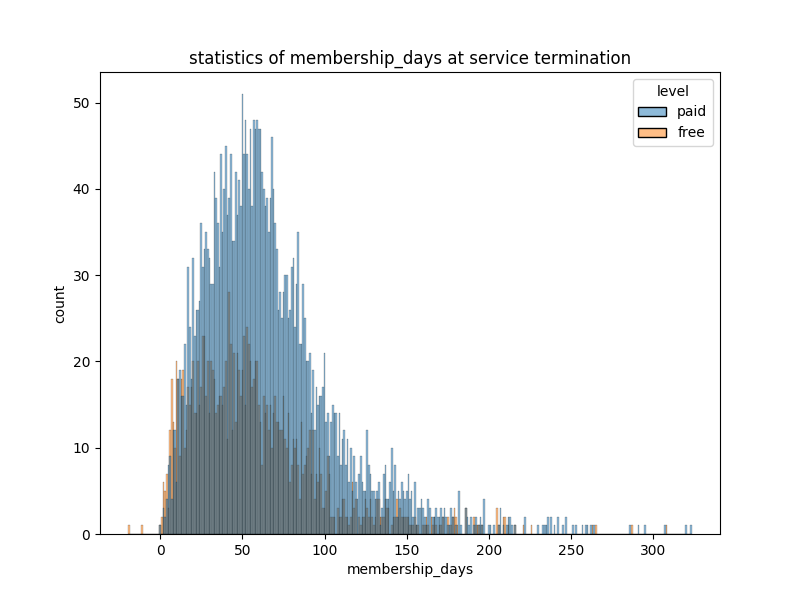

In [18]:
#subscription dependency
plt.clf()
sns.histplot(df_all, x='membership_days', discrete=True, hue='level')
plt.title('statistics of membership_days at service termination')
plt.xlabel('membership_days')
plt.ylabel('count')
%matplot plt

## statistics by week
### user activity by level

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

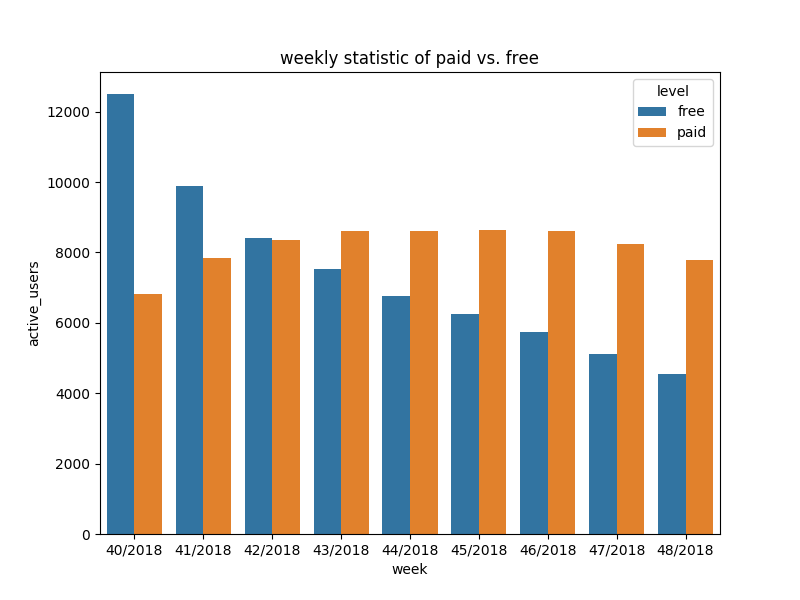

In [19]:
week_stats=spark.sql('''
          SELECT COUNT(DISTINCT userId) as active_users, level, get_week(ts) as week
          FROM user_log_table 
          GROUP BY week, level
          '''
          ).sort("week","level").toPandas()
plt.clf()
sns.barplot(data=week_stats, x='week', y='active_users', hue='level')
plt.title('weekly statistic of paid vs. free')
plt.xlabel('week')
plt.ylabel('active_users')
%matplot plt

### users dropping out by week

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

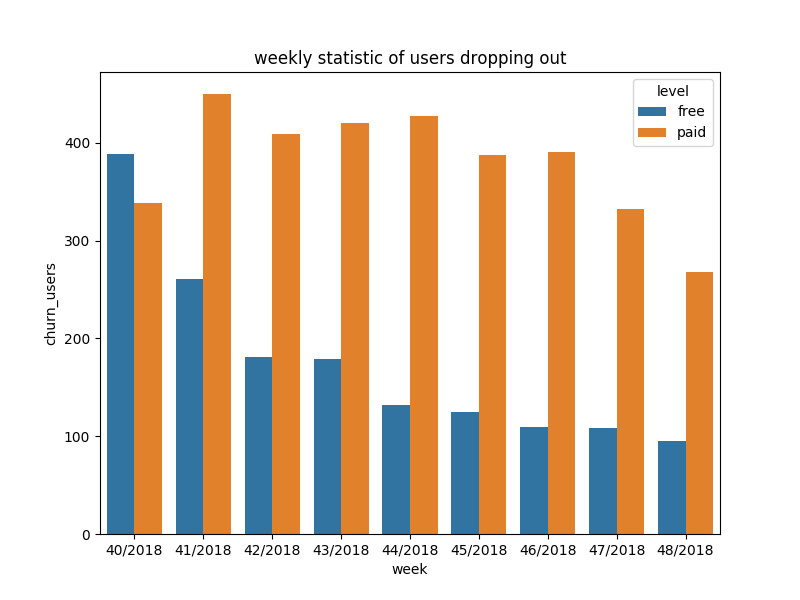

In [20]:
week_stats_3=spark.sql('''
          SELECT COUNT(userId) as churn_users, level, get_week(ts) as week
          FROM user_log_table 
          WHERE page == "Cancellation Confirmation"
          GROUP BY week, level
          '''
          ).sort("week","level").toPandas()
plt.clf()
sns.barplot(data=week_stats_3, x='week', y='churn_users', hue='level')
plt.title('weekly statistic of users dropping out')
plt.xlabel('week')
plt.ylabel('churn_users')
%matplot plt

### new users by week

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

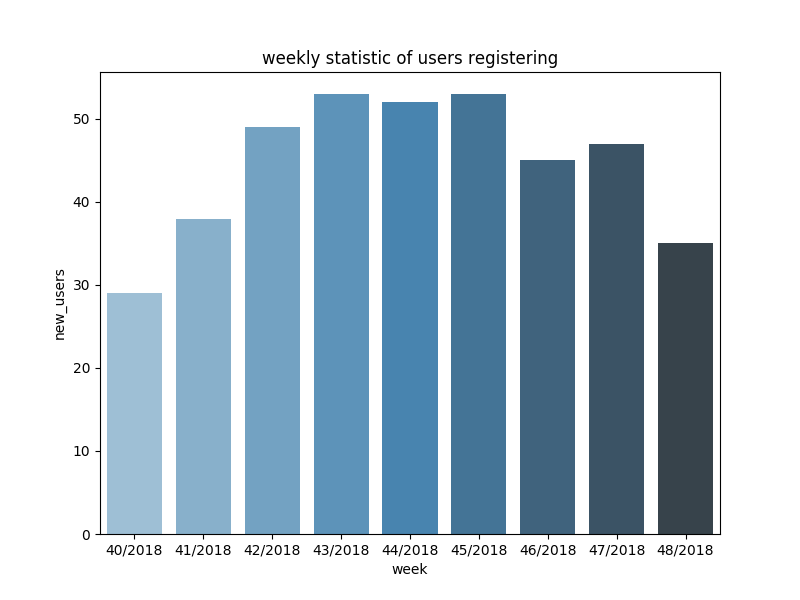

In [21]:
week_stats_2=spark.sql('''
          SELECT COUNT(userId) as new_users, get_week(ts) as week
          FROM user_log_table 
          WHERE page == "Submit Registration"
          GROUP BY week
          '''
          ).sort("week").toPandas()
plt.clf()
sns.barplot(data=week_stats_2, x='week', y='new_users', palette="Blues_d")
plt.title('weekly statistic of users registering')
plt.xlabel('week')
plt.ylabel('new_users')
%matplot plt

### upgrading users by week

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

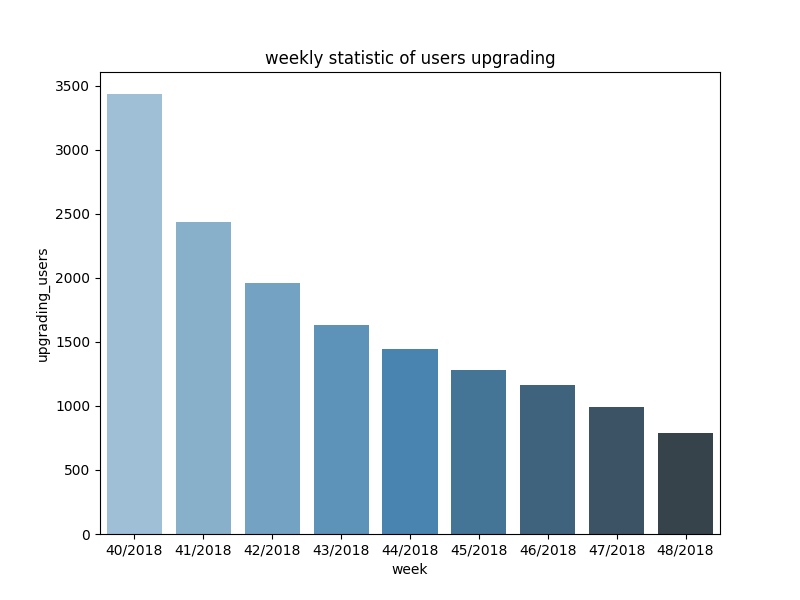

In [22]:
week_stats_4=spark.sql('''
          SELECT COUNT(userId) as upgraded_users, get_week(ts) as week
          FROM user_log_table 
          WHERE page == "Submit Upgrade"
          GROUP BY week, level
          '''
          ).sort("week","level").toPandas()
plt.clf()
sns.barplot(data=week_stats_4, x='week', y='upgraded_users', palette="Blues_d")
plt.title('weekly statistic of users upgrading')
plt.xlabel('week')
plt.ylabel('upgrading_users')
%matplot plt

### downgrading users by week

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

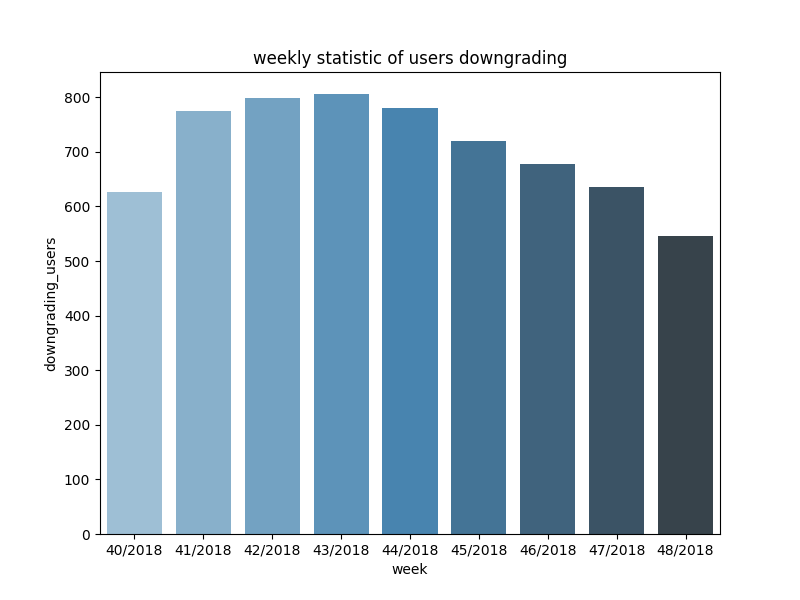

In [23]:
week_stats_5=spark.sql('''
          SELECT COUNT(DISTINCT userId) as downgraded_users, get_week(ts) as week
          FROM user_log_table 
          WHERE page == "Submit Downgrade"
          GROUP BY week, level
          '''
          ).sort("week","level").toPandas()
plt.clf()
sns.barplot(data=week_stats_5, x='week', y='downgraded_users', palette="Blues_d")
plt.title('weekly statistic of users downgrading')
plt.xlabel('week')
plt.ylabel('downgrading_users')
%matplot plt